# S Forecast Examples

## Contents

This notebook demonstrates how to employ sforecast train/test fit (sliding/expanding window out-of-sample train/test) to make forecast fits and predictions with SK Learn Models. The notebook demonstrates the mechanics of setting up and running the corresponding data and models. Mathematical, statistical, and interpretation discussions are out of scope of this notebook. 

 Data and SK Learn ML Models
   * Superstore Data
   * Transforming to Wide Data Format
   * Univariate with XGBoost
   * Multivariate with one output
   * Multivariate with and multiple outputs

## Initialize Notebook

In [4]:
import sforecast as sf
print(f'sforecast version = {sf.__version__}')
import pandas as pd
import numpy as np
import beautifulplots as bp
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from pandas.plotting import autocorrelation_plot
datapath = "../data"

from xgboost import XGBRegressor

sforecast version = 0.1.0


## Superstore Data

Often data needs pre-processing in the form of aggregattions and cleansing so that it is suitable for forecasting. The data for these examples is derived from the Superstore dataset avaliable [here](https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls). In order to not over complicate this notebook we will not demonstrate all the pre-processing here. Howevver, for reference, all the details are contaned in the EDA/pre-procssing notebook  - [pre-processing notebook](https://github.com/Aljgutier/sforecast/blob/main/docs/forecast_EDA_Superstore.ipynb)

Data pre-processing, prior to loading the data, includes the following steps
* contiguous dates - ensure that there are no missing dates
* the data is aggregated to sub category - the original dateset containes categories, sub-categories, and product ids. Below, we will further aggregate to category.

The output of the preprocesing (i.e., data loaded below) is avaialable in this github repo, [pre-processed data](https://github.com/Aljgutier/sforecast/blob/main/data/Superstore_subcatsales_2017_cdp.csv).

 After loading the data there are two additional steps (shown below) to prepare it for forecasting
 * The data will be aggregated to the three categories (office supplies, technology, furniture)
 * It will be transformed to wide format so that all categories are columns

All these transformations (before and after loading) typify transformations required in real situations.

In [5]:
df_sales = pd.read_csv(f'{datapath}/Superstore_subcatsales_2017_cdp.csv', parse_dates = ["Order Date"])
display(df_sales.head(10))

print(f'date min = {df_sales["Order Date"].min()}')
print(f'date max = {df_sales["Order Date"].max()}')
print(f'N rows (sales) = {df_sales.shape[0]}')
print( f'N Sub-Catetories = {df_sales.groupby("Sub-Category")["Sales"].count().count()} ')

,Order Date,Category,Sub-Category,Sales,Quantity
0,2014-01-03,Office Supplies,Paper,16.448,2.0
1,2014-01-04,Office Supplies,Labels,11.784,3.0
2,2014-01-04,Office Supplies,Binders,3.540,2.0
3,2014-01-04,Office Supplies,Paper,0.000,0.0
4,2014-01-04,Office Supplies,Storage,272.736,3.0
5,2014-01-05,Office Supplies,Labels,0.000,0.0
6,2014-01-05,Office Supplies,Binders,0.000,0.0
7,2014-01-05,Office Supplies,Paper,0.000,0.0
8,2014-01-05,Office Supplies,Art,19.536,3.0
9,2014-01-05,Office Supplies,Storage,0.000,0.0


date min = 2014-01-03 00:00:00
date max = 2017-12-30 00:00:00
N rows (sales) = 24431
N Sub-Catetories = 17 


Aggregate to Category Time-Series


* aggregate category sales by date
* three categories - office supplies, furniture, technology
* lineplots to observe the timeseries

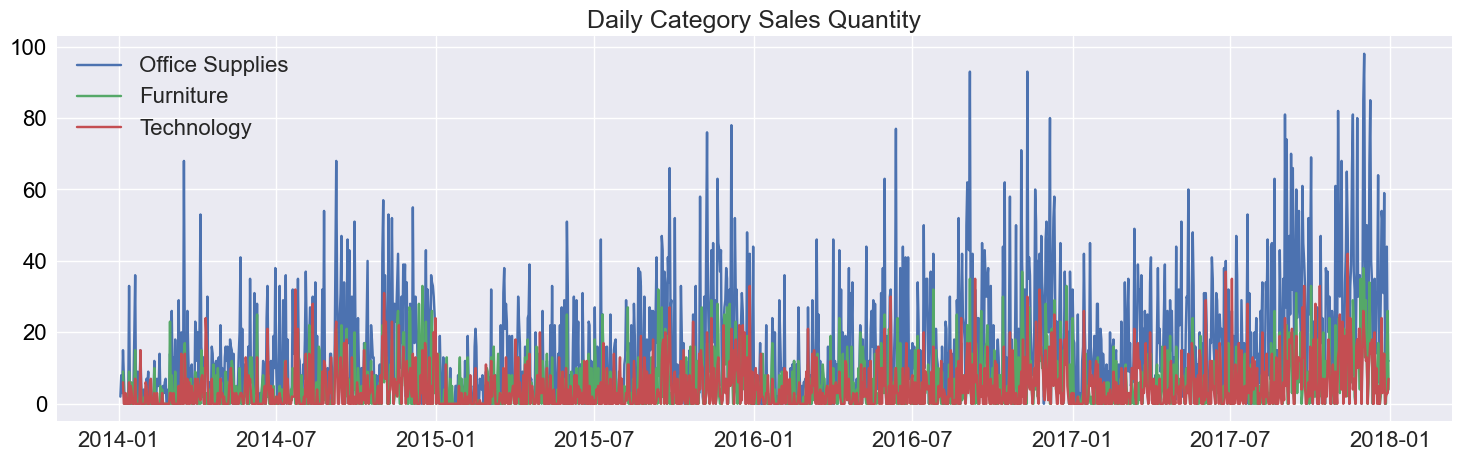

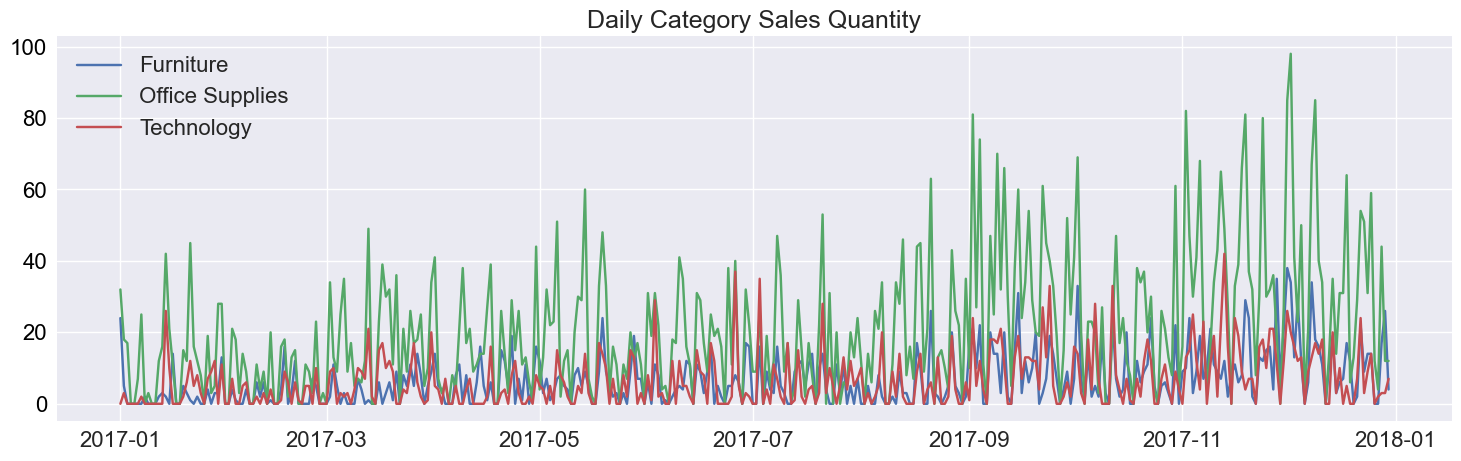

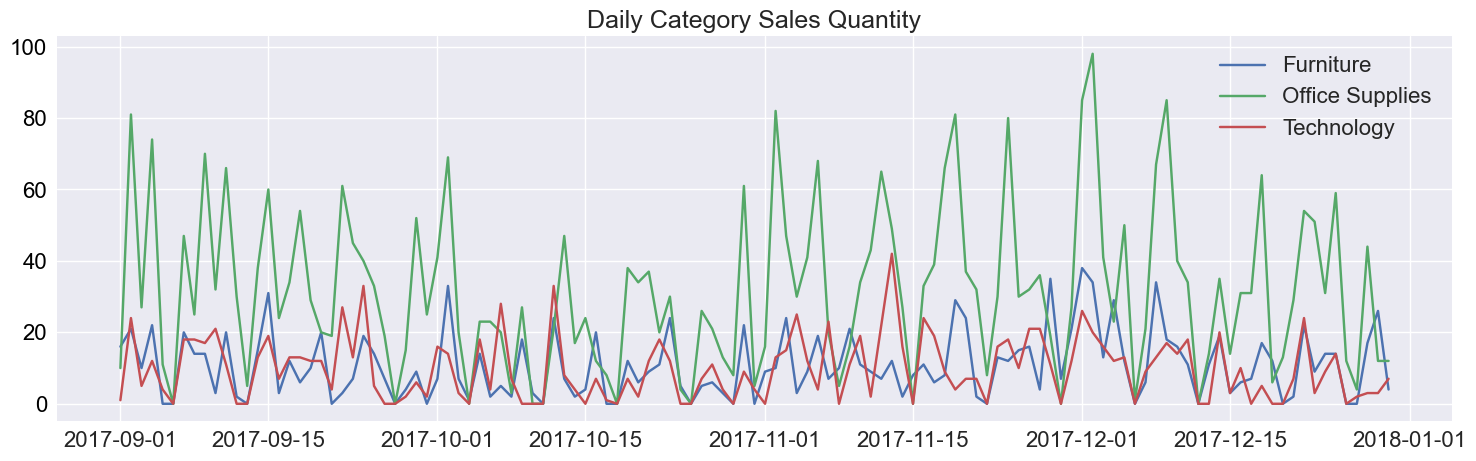

In [6]:
aggs = {
    "Sales":"sum",
    "Quantity":"sum"  
}

df_catsales = df_sales.groupby(["Order Date" , "Category"]).agg(aggs).reset_index()
df_catsales.head(10)

bp.lineplot(df_catsales,"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

d=datetime(2017,1,1)
bp.lineplot(df_catsales[df_catsales["Order Date"]>=d],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

d=datetime(2017,9,1)
bp.lineplot(df_catsales[df_catsales["Order Date"]>=d],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" ,
            title = "Daily Category Sales Quantity", figsize=(18,5))

Wide (Multivariate) Format

* Below is a demonstration of how to pivot the DataFrame to a wide format
* * Wide format will be especially useful for accounting for exogenous variables and covariates.
  * Pivot to wide format - time (index or colum) 
  * ll variables including co-variates in corresponding columns.
* We are interested in forecasting unit sales volume, "Quantity." 
  * We do not need the sales revenue columns.

In [7]:
dfXYw = df_catsales.copy()

def to_flat_columns(hier_cols):
    flat_cols=[]
    for clist in hier_cols:
        for n,ci in enumerate(clist):
            c = ci if n == 0 else c+"_"+ci 
        flat_cols.append(c)
    return flat_cols

dp = "Order Date" # demand period

# demand period (dp) = "Order Date" becomes the index
dfXYw = dfXYw.pivot(index=dp, columns = "Category" , values = ["Quantity" , "Sales"] )
flat_cols = to_flat_columns(dfXYw.columns)
dfXYw.columns = flat_cols 
dfXYw = dfXYw.fillna(0)

display(dfXYw.head(3))

display(dfXYw.tail(7))

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Sales_Furniture,Sales_Office Supplies,Sales_Technology
Order Date,,,,,,
2014-01-03,0.0,2.0,0.0,0.0,16.448,0.0
2014-01-04,0.0,8.0,0.0,0.0,288.060,0.0
2014-01-05,0.0,3.0,0.0,0.0,19.536,0.0


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Sales_Furniture,Sales_Office Supplies,Sales_Technology
Order Date,,,,,,
2017-12-24,14.0,31.0,9.0,1393.4940,1479.638,3359.922
2017-12-25,14.0,59.0,14.0,832.4540,1465.265,401.208
2017-12-26,0.0,12.0,0.0,0.0000,814.594,0.000
2017-12-27,0.0,4.0,2.0,0.0000,13.248,164.388
2017-12-28,17.0,44.0,3.0,551.2568,1091.244,14.850
2017-12-29,26.0,12.0,3.0,2330.7180,282.440,302.376
2017-12-30,4.0,12.0,7.0,323.1360,299.724,90.930


## Univariate

Univariate forecast considers only one variable
  * Slideing forecast: 30 day sliding forecast, Ntest = 30 days
  * Predict horizon:  Nhorizon = 1. The model is retrained after every Nhorizon time periods. Out-of-sample predictions are made to account for new observation after sliding over by 1 time period.
  * Target Variable: y = "Quantity_Furniture"
  * Lags: Nlags = 40. The univariate (y) will be lagged over 40 days.
  * ML model: In this case the model is an untrained XGBoost model. Generally, any SK Learn model can be input to sforecast
  * Output: DataFrame with output predictions, upper lower bounds, error wrt to target variable. Join the forecast result with the input DataFrame dfXY
  * Data scaling: By default the sliding model will scale the input variables with the SKlearn minmax scaler (normalization). However, sforecast offers the option to scale with the StandardScaler (standardization). 
  * See the [sforecast](https://sforecast.readthedocs.io/en/latest/) documentaton for more information.


In [9]:
dfXY = dfXYw[["Quantity_Furniture"]].copy()

print('dfXY')
display(dfXY.tail())

Ntest = 30
Nhorizon = 1

swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "minmax" :(0,None)}  

y = ["Quantity_Furniture"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

sfxgbuv = sf.sforecast(y = y, swin_parameters=swin_params,model=xgb_model,model_type="sk")

df_pred_xgbuv = sfxgbuv.fit(dfXY)

print(f'\nmetrics = {sfxgbuv.metrics}')


dfXY_pred_xgbuv = dfXY.join(df_pred_xgbuv)
display(dfXY_pred_xgbuv)


dfXY


,Quantity_Furniture
Order Date,
2017-12-26,0.0
2017-12-27,0.0
2017-12-28,17.0
2017-12-29,26.0
2017-12-30,4.0



metrics = {'Quantity_Furniture_pred': {'RMSE': 10.93991802246071, 'MAE': 8.818413734436035}}


,Quantity_Furniture,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,,
2014-01-03,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,9.0,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2017-12-26,0.0,NaN,0.0,8.522676,8.522676,0.0,18.624882
2017-12-27,0.0,NaN,0.0,5.819362,5.819362,0.0,15.921568
2017-12-28,17.0,NaN,17.0,10.800791,-6.199209,0.0,20.902997


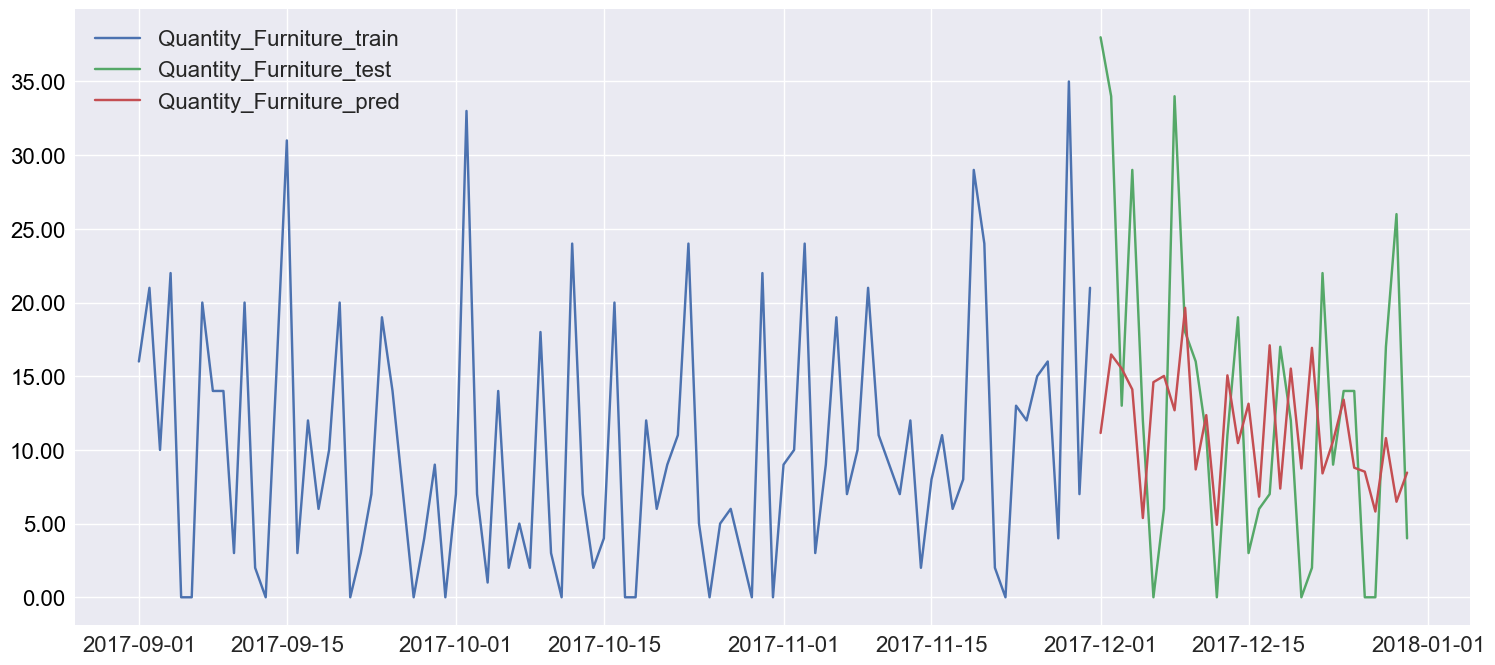

In [10]:

y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfxgbuv = dfXY_pred_xgbuv.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

d=datetime(2017,9,1)
bp.lineplot(dfxgbuv[dfxgbuv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8) , legend=True)

**Predict SK XGB univariate**

In [12]:
ts_period = pd.DateOffset(days=1)
df_pred=sfxgbuv.predict(Nperiods=5,ts_period=ts_period)
df_pred

,Quantity_Furniture_pred
2017-12-31,12.184675
2018-01-01,1.541578
2018-01-02,7.114231
2018-01-03,6.822329
2018-01-04,5.160534


## Train Test and Validation

The purpose of this next exericise is for validation of our predictions against unseen data. The key goal is to validate that the out-of-sample predictions are the same as for predictions on unseen data. Below is the process for validating the out-of-sample predictions are correct.

Step 1. Create training/Test and validation (holdout set) data sets.   

Step 2.  Train Test with sforecast -  slidng forecast out of sample training and test, N-step recursive forecast methodFit the forecast model using the train/test data set

Step 3: Train (fit) using train set (separate from the validation set) ... 5 x 1-step recursive forward forecasts (should be identical to the above results)

Step 4. Compare the results of the two methods and ensure they produce identical forecasts.

Step 1: Create Data Sets - Train/Test and Validation

(1458, 6)


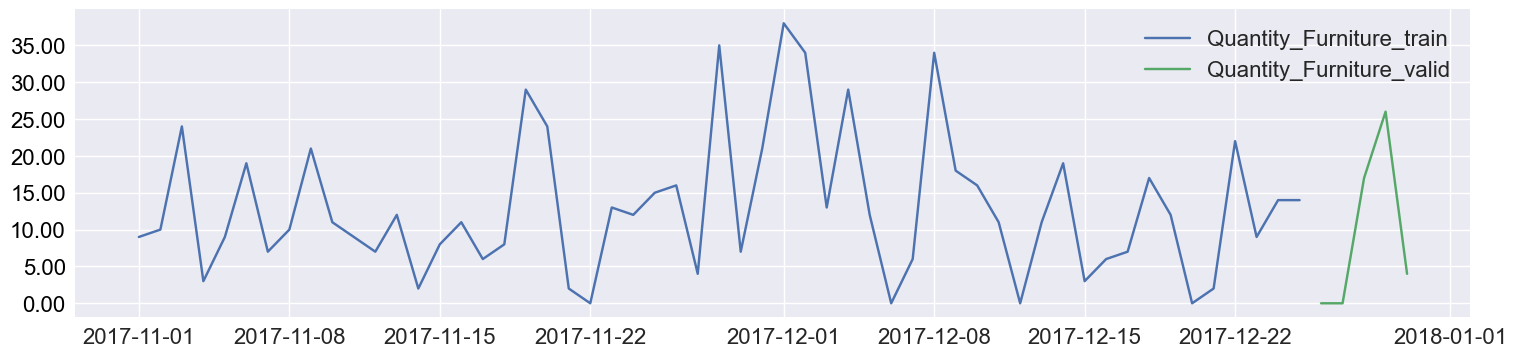

In [13]:
print(dfXYw.shape)
dfXY_traintest = dfXYw[["Quantity_Furniture"]]
dfXY_train = dfXYw[["Quantity_Furniture"]][:1453]
dfXY_train.columns = ["Quantity_Furniture_train"]
dfXY_valid = dfXYw[["Quantity_Furniture"]][1453:]
dfXY_valid.columns = ["Quantity_Furniture_valid"]

# plot
dfXY_train_valid_pred = pd.concat([dfXY_train, dfXY_valid])
dfXY_plot = dfXY_train_valid_pred.reset_index()
bp.lineplot(dfXY_plot.tail(60), x= "Order Date", y=["Quantity_Furniture_train", "Quantity_Furniture_valid"  ] , figsize=(18,4) , legend=True)

Step 2: model fit dfXY_traintest train and fit over all observations using out-of-sample prediction method with forecast horizon 5 ... 5 x 1-step recursive forecasts

In [14]:
# Step 2 a: Fit
Ntest = 5
Nhorizon = 5
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "minmax" :(0,None)}  

y = ["Quantity_Furniture"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 
sfmodel_1 = sf.sforecast(y = y, swin_parameters=swin_params,model=xgb_model,model_type="sk")
df_pred=sfmodel_1.fit(dfXY_traintest)

# housekeeping ... df_pred5_s2 
df_pred5_s2=df_pred[["Quantity_Furniture_pred"]].tail(5)
df_pred5_s2.columns = ["Quantity_Furniture_pred_s2"]
df_pred5_s2


,Quantity_Furniture_pred_s2
Order Date,
2017-12-26,8.522676
2017-12-27,11.428208
2017-12-28,10.761415
2017-12-29,9.716197
2017-12-30,15.281743


Step 3: Train (fit) using train set (separate from the validation set) ... 5 x 1-step recursive forward forecasts (should be identical to the above results)

In [15]:
# Step 3 a: Fit on dfXY_train

Ntest = 0
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "minmax" :(0,None)}  
y = ["Quantity_Furniture_train"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 
sfmodel_2 = sf.sforecast(y = y, swin_parameters=swin_params,model=xgb_model,model_type="sk")
sfmodel_2.fit(dfXY_train)

# Step 2 b: Predict the next 5 days
ts_period = pd.DateOffset(days=1)
df_pred5_s3=sfmodel_2.predict(Nperiods=5,ts_period=ts_period)

# housekeeping ... df_pred5_s2 ... change column name for convenience
df_pred5_s3.columns = ["Quantity_Furniture_pred_s3"]
df_pred5_s3


,Quantity_Furniture_pred_s3
2017-12-26,8.522676
2017-12-27,11.428208
2017-12-28,10.761415
2017-12-29,9.716197
2017-12-30,15.281743


Step 4. Compare the results of the two methods
* Step 2: model fit dfXY_traintes, train and fit over all observations using out-of-sample prediction method with forecast horizon 5 ... 5 x 1-step recursive forecasts
* Step 3 - model fit on training data (dfXY_train). Valdation data, last 5 days is unseen. After the fit, perform a 5 day forward predict forecast with recursive 1-step forecast over 5 days

We see that both predictions above are identical which proves that s-forecast out-of-sample sliding forecast is not leaking test/observation information data into the training set. 

,Quantity_Furniture_train,Quantity_Furniture_pred_s2,Quantity_Furniture_pred_s3,Quantity_Furniture_valid
Order Date,,,,
2017-12-21,2.0,NaN,NaN,NaN
2017-12-22,22.0,NaN,NaN,NaN
2017-12-23,9.0,NaN,NaN,NaN
2017-12-24,14.0,NaN,NaN,NaN
2017-12-25,14.0,NaN,NaN,NaN
2017-12-26,NaN,8.522676,8.522676,0.0
2017-12-27,NaN,11.428208,11.428208,0.0
2017-12-28,NaN,10.761415,10.761415,17.0
2017-12-29,NaN,9.716197,9.716197,26.0


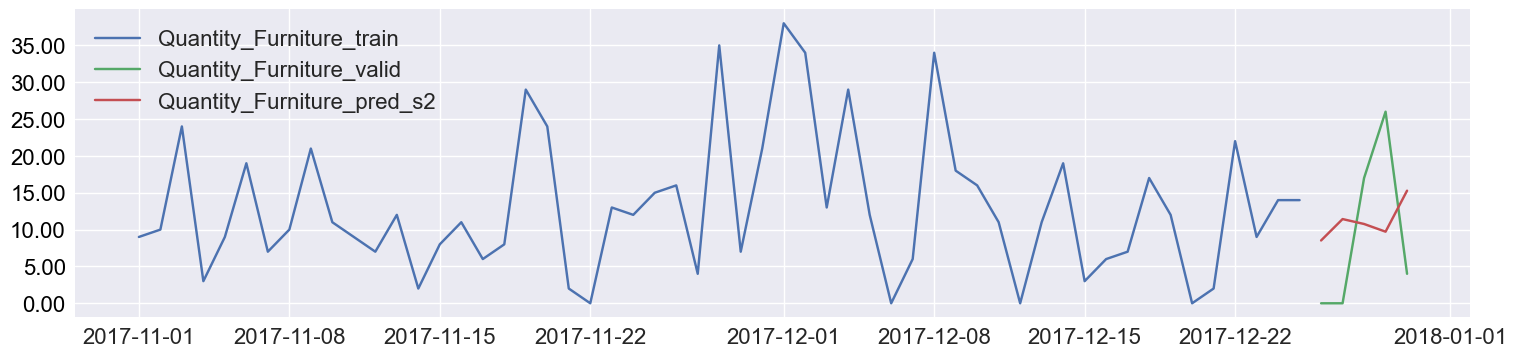

In [18]:
# Join the training, predictions and validations for easy comparison 
dfXY_testtrainpred = pd.concat([dfXY_train, df_pred5_s2])
dfXY_testtrainpred = dfXY_testtrainpred.join(df_pred5_s3)
dfXY_testtrainpred = dfXY_testtrainpred.join(dfXY_valid)

display(dfXY_testtrainpred.tail(10))

# plot
dfXY_plot = dfXY_testtrainpred.reset_index()
bp.lineplot(dfXY_plot.tail(60), x= "Order Date", y=["Quantity_Furniture_train", "Quantity_Furniture_valid","Quantity_Furniture_pred_s2"  ] , figsize=(18,4) , legend=True)

## Univariate Exogenous, Endogenous/derived variabless

**Exogenous Variables**

These variables are not dependent on the target (independent variable) and are ususally some form of external varialbe. For example, they could represent the weather, such as temperature or rain, or economic data, such as consumer confience index.

The exogenous variables are included in the input dataframe to the fit operation. An exogenous variables dataframe, one row per predict period is input to the predict operation.

Below is trivial example of exogenous variables, the month number is included as an exogenous variable input. df_airp has two variables the target variable and y = Passengers, and exogenous variable month_no

In [19]:
# deirvied variables transform

# derived attributes custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline/transformer development
# BaseEstimater ... get_params(), set_params() methods
# TransformerMixin ... fit_transform() method
Nr = 3
class derived_attributes(BaseEstimator,TransformerMixin):
    def __init__(self, Nr = Nr): 
        self.Nr = Nr # slidig/rolling window rows
        self.dfmemory = None
    
    def fit(self,df):
        # ensure dataframe has enough rows
        self.dfmemory = df.tail(self.Nr) if df.index.size > self.Nr else df.index.size
        return self
    
    def transform(self,df=None, Nout=None, dfnewrows=None):
        # if df not spefified then transform on dfmemory
        # add new row(s) ... these will be provided from the predict operation
        if not isinstance(df,pd.DataFrame):
            df = self.dfmemory
            if isinstance(dfnewrows,pd.DataFrame):
                df = pd.concat([df,dfnewrows])
        self.dfmemory = df.tail(self.Nr) 
        Nr=self.Nr
        dfnew=df.copy()
        
        dfnew["Quantity_Furniture_m1_ravg"+str(Nr)] = dfnew["Quantity_Furniture_m1"].rolling(window=Nr).mean()  
        dfnew["Quantity_Furniture_m1_rstd"+str(Nr)] = dfnew["Quantity_Furniture_m1"].rolling(window=Nr).std()
        # dfnew=dfnew.iloc[Nr:] # do not toss out first Nr rows since they will be NA  this will be managed by sforecast
    
        Nclip = self.Nr
        return dfnew if Nout == None else dfnew.tail(Nout)
    
    def get_Nclip(self): # returns the number of initial rows are desgarded (clipped) for NaN avoidence
        return self.Nr
    
    def get_derived_attribute_names(self):
        Nr = self.Nr
        return [ "Quantity_Furniture_m1_ravg"+str(Nr), "Quantity_Furniture_m1_rstd"+str(Nr) ]
 
cols = ["Quantity_Furniture"]        
dfXY_m1 = dfXYw[cols].copy()


# the variables eill be created by sforecast
# here we test the transform to see what the new variables look like.
Nclip =derived_attributes().get_Nclip()
print("Nclip =",Nclip)
drived_var_transform = derived_attributes()
dfXY_m1["Quantity_Furniture_m1"] = dfXY_m1["Quantity_Furniture"].shift(1)
dftest = drived_var_transform.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest)

print(f'Nr= {Nr} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(drived_var_transform.dfmemory)

Nclip = 3
dataframe, dftest, with derived variables


,Quantity_Furniture,Quantity_Furniture_m1,Quantity_Furniture_m1_ravg3,Quantity_Furniture_m1_rstd3
Order Date,,,,
2014-01-03,0.0,NaN,NaN,NaN
2014-01-04,0.0,0.0,NaN,NaN
2014-01-05,0.0,0.0,NaN,NaN
2014-01-06,9.0,0.0,0.000000,0.000000
2014-01-07,3.0,9.0,3.000000,5.196152
...,...,...,...,...
2017-12-26,0.0,14.0,12.333333,2.886751
2017-12-27,0.0,0.0,9.333333,8.082904
2017-12-28,17.0,0.0,4.666667,8.082904


Nr= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


,Quantity_Furniture,Quantity_Furniture_m1
Order Date,,
2017-12-28,17.0,0.0
2017-12-29,26.0,17.0
2017-12-30,4.0,26.0


In [29]:
dfXY = dfXYw[["Quantity_Furniture"]].copy()

# Exogenous Variables
dfXY["dayofweek"] = dfXY.index.dayofweek

print('dfXY')
display(dfXY.head())

Ntest = 30
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "exogvars": "dayofweek",
    "minmax" :(0,None),
    "derived_attributes_transform":derived_attributes # Endogenous Variables
    }  

y = ["Quantity_Furniture"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

sfxgbuv = sf.sforecast(y = y, swin_parameters=swin_params,model=xgb_model,model_type="sk")

df_pred = sfxgbuv.fit(dfXY)

display(df_pred_xgbuv.tail(5))

print(f'\nmetrics = {sfxgbuv.metrics}')

dfXY_pred = dfXY.join(df_pred)

display(dfXY_pred)

dfXY


,Quantity_Furniture,dayofweek
Order Date,,
2014-01-03,0.0,4
2014-01-04,0.0,5
2014-01-05,0.0,6
2014-01-06,9.0,0
2014-01-07,3.0,1


,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,
2017-12-26,NaN,0.0,13.802155,13.802155,0.0,25.416108
2017-12-27,NaN,0.0,6.074481,6.074481,0.0,17.688434
2017-12-28,NaN,17.0,10.371642,-6.628358,0.0,21.985595
2017-12-29,NaN,26.0,16.953768,-9.046232,0.0,28.567721
2017-12-30,NaN,4.0,10.460499,6.460499,0.0,22.074452



metrics = {'Quantity_Furniture_pred': {'RMSE': 11.268757705882695, 'MAE': 8.683470225334167}}


,Quantity_Furniture,dayofweek,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,,,
2014-01-03,0.0,4,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,5,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,6,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,0,9.0,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,1,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2017-12-26,0.0,1,NaN,0.0,13.802155,13.802155,0.0,25.416108
2017-12-27,0.0,2,NaN,0.0,6.074481,6.074481,0.0,17.688434
2017-12-28,17.0,3,NaN,17.0,10.371642,-6.628358,0.0,21.985595


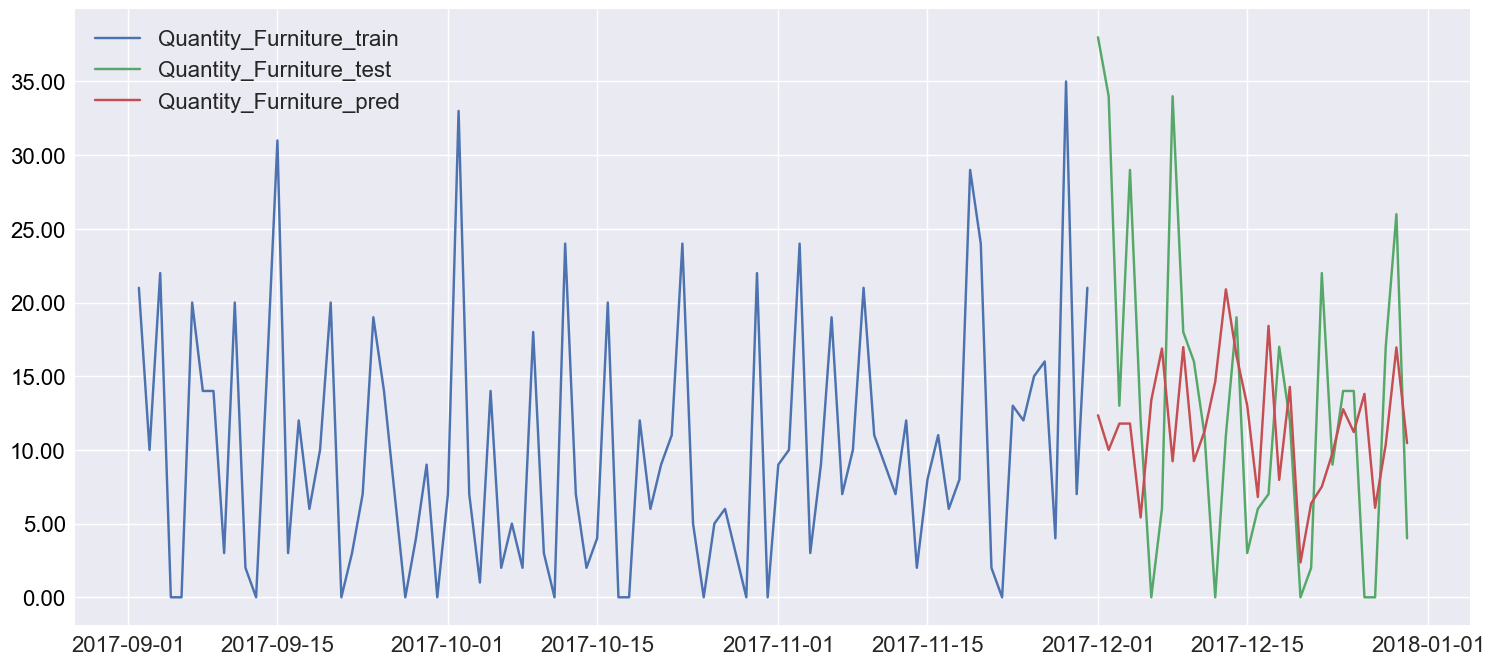

In [30]:

y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfplot = dfXY_pred.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

bp.lineplot(dfplot.tail(120), x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8) , legend=True)

**Predict with Exogenous Variables and Engogenous/Derived Variables**

In [31]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"dayofweek":[2,3]})
df_pred=sfxgbuv.predict(Nperiods = 2, dfexogs = dfexogs, ts_period=ts_period)
df_pred

,Quantity_Furniture_pred
2017-12-31,8.322301
2018-01-01,12.238869


## Multivariate, Exogenous, Endogenous, one Output


* this case is similar to the previous one, but also includes the covariates in the dfXY dataset
* initialize the sliding window model as before
* we must declare the covariates so that they are accounted for properly - unlagged covariates are not included in the training set
* we have an improved forecast accuracy for y = Quantity_Furniture: RMSE': 9.83, 'MAE': 7.36
* when comparing the previous example's lineplot we notice improved accuracy. In this example the predicted line follows the actual ("test") line a little more closely. 

forecast fit

In [37]:
dfXY = dfXYw[["Quantity_Furniture","Quantity_Office Supplies", "Quantity_Technology" ]].copy()
y = ["Quantity_Furniture"]

# Exogenous Variables
dfXY["dayofweek"] = dfXY.index.dayofweek

print('dfXY')
display(dfXY.tail())

Ntest = 30
Nhorizon = 5

swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "minmax" :(0,None),
    "exogvars" : "dayofweek",
    "covars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]} 

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 
sfxgbmv1 = sf.sforecast(y = y, swin_parameters=swin_params,model=xgb_model, model_type="sk")
df_pred_xgbmv1 = sfxgbmv1.fit(dfXY)

print(f'\nmetrics = {sfxgbmv1.metrics}')
dfXY_pred_xgbmv1 = dfXY.join(df_pred_xgbmv1)
display(dfXY_pred_xgbmv1.tail(10))

dfXY


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,dayofweek
Order Date,,,,
2017-12-26,0.0,12.0,0.0,1
2017-12-27,0.0,4.0,2.0,2
2017-12-28,17.0,44.0,3.0,3
2017-12-29,26.0,12.0,3.0,4
2017-12-30,4.0,12.0,7.0,5



metrics = {'Quantity_Furniture_pred': {'RMSE': 10.78427655074975, 'MAE': 8.447838127613068}}


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,dayofweek,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,,,,,
2017-12-21,2.0,29.0,7.0,3,NaN,2.0,13.272618,11.272618,0.000000,23.652149
2017-12-22,22.0,54.0,24.0,4,NaN,22.0,12.201632,-9.798368,0.000000,24.408145
2017-12-23,9.0,51.0,3.0,5,NaN,9.0,7.805322,-1.194678,0.000000,8.109241
2017-12-24,14.0,31.0,9.0,6,NaN,14.0,8.895321,-5.104679,0.000000,7.844614
2017-12-25,14.0,59.0,14.0,0,NaN,14.0,8.353712,-5.646288,2.689710,23.579058
2017-12-26,0.0,12.0,0.0,1,NaN,0.0,9.486443,9.486443,0.000000,19.865973
2017-12-27,0.0,4.0,2.0,2,NaN,0.0,2.487508,2.487508,0.000000,14.694021
2017-12-28,17.0,44.0,3.0,3,NaN,17.0,18.025175,1.025175,2.894238,18.329094
2017-12-29,26.0,12.0,3.0,4,NaN,26.0,17.461369,-8.538631,6.747799,16.410662


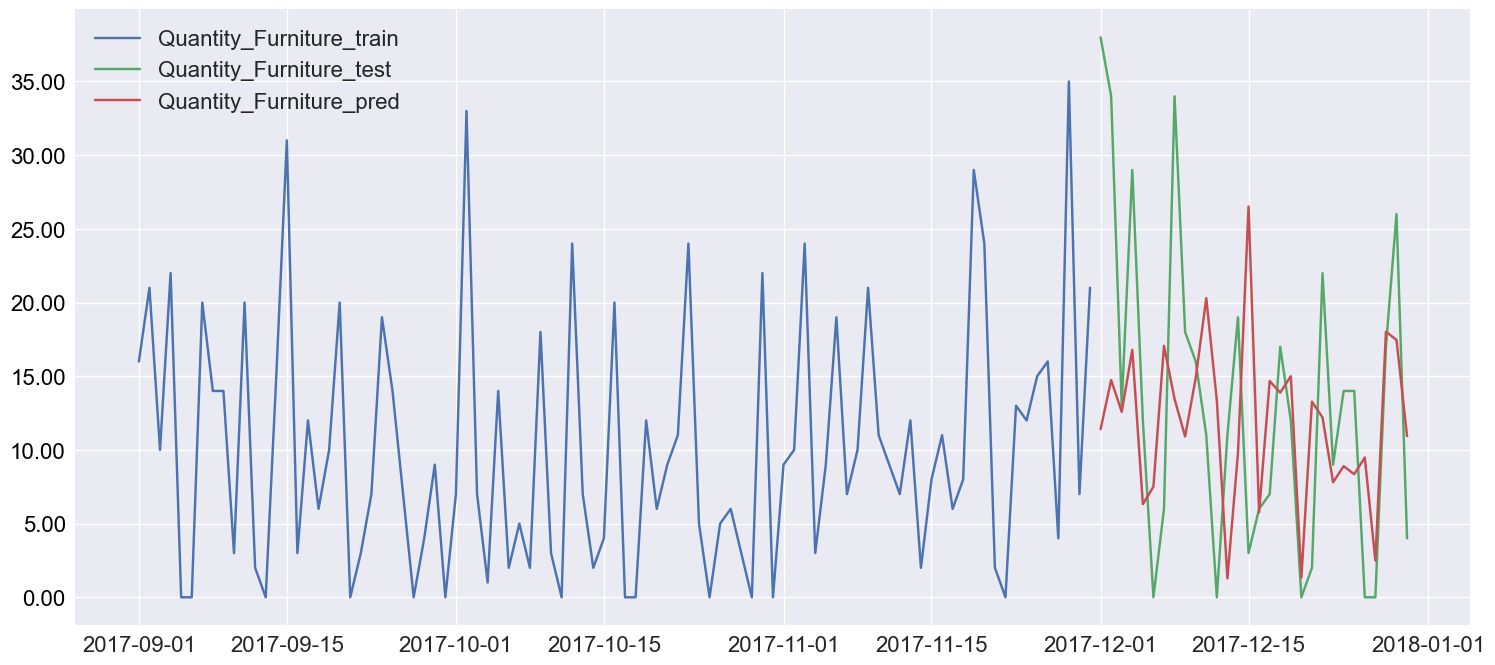

In [38]:
y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfxgbmv1 = dfXY_pred_xgbmv1.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

d=datetime(2017,9,1)
bp.lineplot(dfxgbmv1[dfxgbmv1["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8))

## Multivariate, Exogenous, Endogenous, Multiple Outputs

**3 derived attributes**

In [39]:
# deirvied variables transform

# derived attributes custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline/transformer development
# BaseEstimater ... get_params(), set_params() methods
# TransformerMixin ... fit_transform() method
Nr = 3
class derived_attributes_3(BaseEstimator,TransformerMixin):
    def __init__(self, Nr = Nr): 
        self.Nr = Nr # slidig/rolling window rows
        self.dfmemory = None
    
    def fit(self,df):
        # ensure dataframe has enough rows
        self.dfmemory = df.tail(self.Nr) if df.index.size > self.Nr else df.index.size
        return self
    
    def transform(self,df=None, Nout=None, dfnewrows=None):
        # if df not spefified then transform on dfmemory
        # add new row(s) ... these will be provided from the predict operation
        if not isinstance(df,pd.DataFrame):
            df = self.dfmemory
            if isinstance(dfnewrows,pd.DataFrame):
                df = pd.concat([df,dfnewrows])
        self.dfmemory = df.tail(self.Nr) 
        Nr=self.Nr
        dfnew=df.copy()
        
        dfnew["Quantity_Furniture_m1_ravg"+str(Nr)] = dfnew["Quantity_Furniture_m1"].rolling(window=Nr).mean()  
        dfnew["Quantity_Furniture_m1_rstd"+str(Nr)] = dfnew["Quantity_Furniture_m1"].rolling(window=Nr).std()
        dfnew["Quantity_Office_Supplies_m1_ravg"+str(Nr)] = dfnew["Quantity_Office Supplies_m1"].rolling(window=Nr).mean()  
        dfnew["Quantity_Office_Supplies_m1_rstd"+str(Nr)] = dfnew["Quantity_Office Supplies_m1"].rolling(window=Nr).std()
        dfnew["Quantity_Technology_m1_ravg"+str(Nr)] = dfnew["Quantity_Technology_m1"].rolling(window=Nr).mean()  
        dfnew["Quantity_Technology_m1_rstd"+str(Nr)] = dfnew["Quantity_Technology_m1"].rolling(window=Nr).std()
        # dfnew=dfnew.iloc[Nr:] # do not toss out first Nr rows since they will be NA  this will be managed by sforecast
    
        Nclip = self.Nr
        return dfnew if Nout == None else dfnew.tail(Nout)
    
    def get_Nclip(self): # returns the number of initial rows are desgarded (clipped) for NaN avoidence
        return self.Nr
    
    def get_derived_attribute_names(self):
        Nr = self.Nr
        return [ "Quantity_Furniture_m1_ravg"+str(Nr), "Quantity_Furniture_m1_rstd"+str(Nr),
                "Quantity_Office_Supplies_m1_ravg"+str(Nr), "Quantity_Office_Supplies_m1_rstd"+str(Nr),
                "Quantity_Technology_m1_ravg"+str(Nr), "Quantity_Technology_m1_rstd"+str(Nr)
                ]
 
cols = ["Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]        
dfXY_m1 = dfXYw[cols].copy()


# the variables eill be created by sforecast
# here we test the transform to see what the new variables look like.
Nclip =derived_attributes_3().get_Nclip()
print("Nclip =",Nclip)
drived_var_transform = derived_attributes_3()
dfXY_m1[["Quantity_Furniture_m1", "Quantity_Office Supplies_m1","Quantity_Technology_m1" ]] = dfXY_m1[["Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"  ]].shift(1)
dftest = drived_var_transform.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest)

print(f'Nr= {Nr} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(drived_var_transform.dfmemory)

Nclip = 3
dataframe, dftest, with derived variables


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Quantity_Furniture_m1,Quantity_Office Supplies_m1,Quantity_Technology_m1,Quantity_Furniture_m1_ravg3,Quantity_Furniture_m1_rstd3,Quantity_Office_Supplies_m1_ravg3,Quantity_Office_Supplies_m1_rstd3,Quantity_Technology_m1_ravg3,Quantity_Technology_m1_rstd3
Order Date,,,,,,,,,,,,
2014-01-03,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,8.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,3.0,0.0,0.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,15.0,6.0,0.0,3.0,0.0,0.000000,0.000000,4.333333,3.214550,0.000000,0.000000
2014-01-07,3.0,7.0,0.0,9.0,15.0,6.0,3.000000,5.196152,8.666667,6.027714,2.000000,3.464102
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,0.0,12.0,0.0,14.0,59.0,14.0,12.333333,2.886751,47.000000,14.422205,8.666667,5.507571
2017-12-27,0.0,4.0,2.0,0.0,12.0,0.0,9.333333,8.082904,34.000000,23.643181,7.666667,7.094599
2017-12-28,17.0,44.0,3.0,0.0,4.0,2.0,4.666667,8.082904,25.000000,29.715316,5.333333,7.571878


Nr= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Quantity_Furniture_m1,Quantity_Office Supplies_m1,Quantity_Technology_m1
Order Date,,,,,,
2017-12-28,17.0,44.0,3.0,0.0,4.0,2.0
2017-12-29,26.0,12.0,3.0,17.0,44.0,3.0
2017-12-30,4.0,12.0,7.0,26.0,12.0,3.0


In [40]:
dfXY = dfXYw[["Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]].copy()

# Exogenous Variables
dfXY["dayofweek"] = dfXY.index.dayofweek

print("dfXY")
display(dfXY.head())


y = [ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]
Ntest= 30
Nhorizon = 1
# sliding forecast inputs
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "minmax" :(0,None),
    "covars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"],
    "exogvars":"dayofweek",
    "derived_attributes_transform":derived_attributes_3 # Endogenous Variables
    } 


xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

# sliding forecast model and forecast
sfxgbmv = sf.sforecast(y = y, swin_parameters=swin_params,model=xgb_model,model_type="sk")
df_pred_xgbmv = sfxgbmv.fit(dfXY)


print(f'\nmetrics = {sfxgbmv.metrics}')

print("confidence intervals, 1 to Nh = ",sfxgbmv.ci )

dfXY_pred_xgbmv = dfXY.join(df_pred_xgbmv)
display(dfXY_pred_xgbmv)

dfXY


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,dayofweek
Order Date,,,,
2014-01-03,0.0,2.0,0.0,4
2014-01-04,0.0,8.0,0.0,5
2014-01-05,0.0,3.0,0.0,6
2014-01-06,9.0,15.0,6.0,0
2014-01-07,3.0,7.0,0.0,1



metrics = {'Quantity_Furniture_pred': {'RMSE': 9.8486353734835, 'MAE': 7.366431101163228}, 'Quantity_Office Supplies_pred': {'RMSE': 22.649182573120264, 'MAE': 15.80677916208903}, 'Quantity_Technology_pred': {'RMSE': 7.403682683708571, 'MAE': 5.99887033700943}}
confidence intervals, 1 to Nh =  {'Quantity_Furniture': [(-14.876869773864746, 6.49545526504517)], 'Quantity_Office Supplies': [(-36.66603240966797, 17.70495643615723)], 'Quantity_Technology': [(-7.866886711120604, 9.409889793395998)]}


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,dayofweek,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper,...,Quantity_Office Supplies_pred,Quantity_Office Supplies_pred_error,Quantity_Office Supplies_pred_lower,Quantity_Office Supplies_pred_upper,Quantity_Technology_train,Quantity_Technology_test,Quantity_Technology_pred,Quantity_Technology_pred_error,Quantity_Technology_pred_lower,Quantity_Technology_pred_upper
Order Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,0.0,2.0,0.0,4,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,8.0,0.0,5,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,3.0,0.0,6,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,15.0,6.0,0,9.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,7.0,0.0,1,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,0.0,12.0,0.0,1,NaN,0.0,6.255946,6.255946,0.000000,12.751401,...,14.250632,2.250632,0.0,31.955589,NaN,0.0,0.700436,0.700436,0.000000,10.110325
2017-12-27,0.0,4.0,2.0,2,NaN,0.0,4.276994,4.276994,0.000000,10.772449,...,8.977273,4.977273,0.0,26.682229,NaN,2.0,2.382568,0.382568,0.000000,11.792457
2017-12-28,17.0,44.0,3.0,3,NaN,17.0,14.355412,-2.644588,0.000000,20.850867,...,35.066746,-8.933254,0.0,52.771702,NaN,3.0,15.168377,12.168377,7.301490,24.578267


Plot

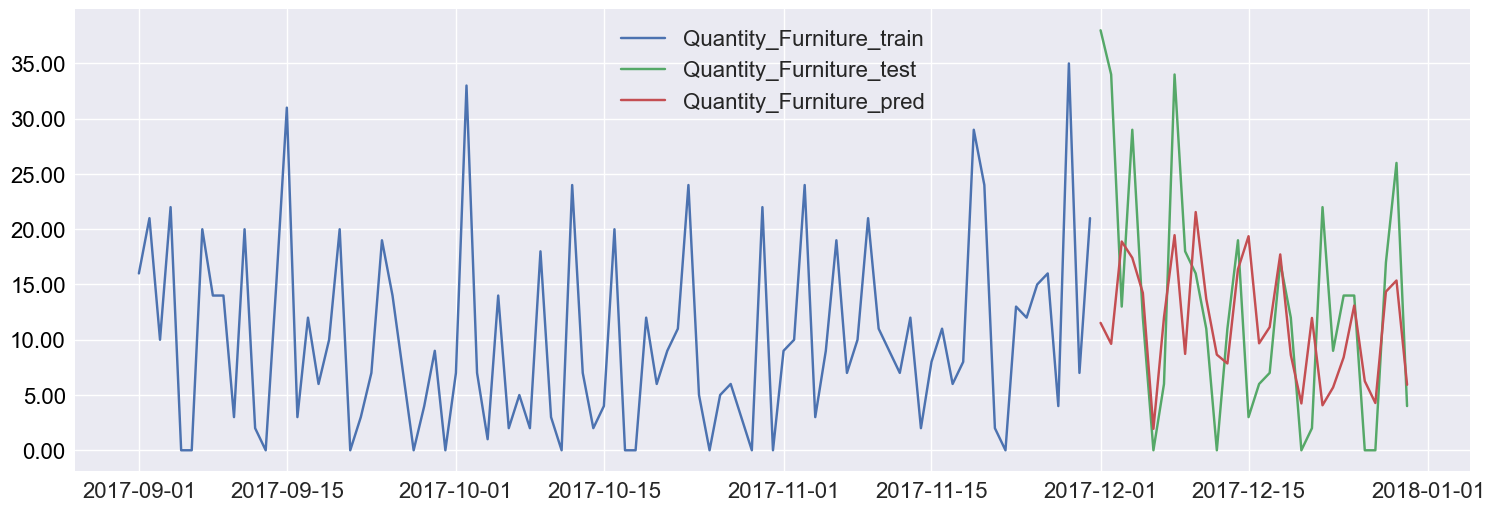

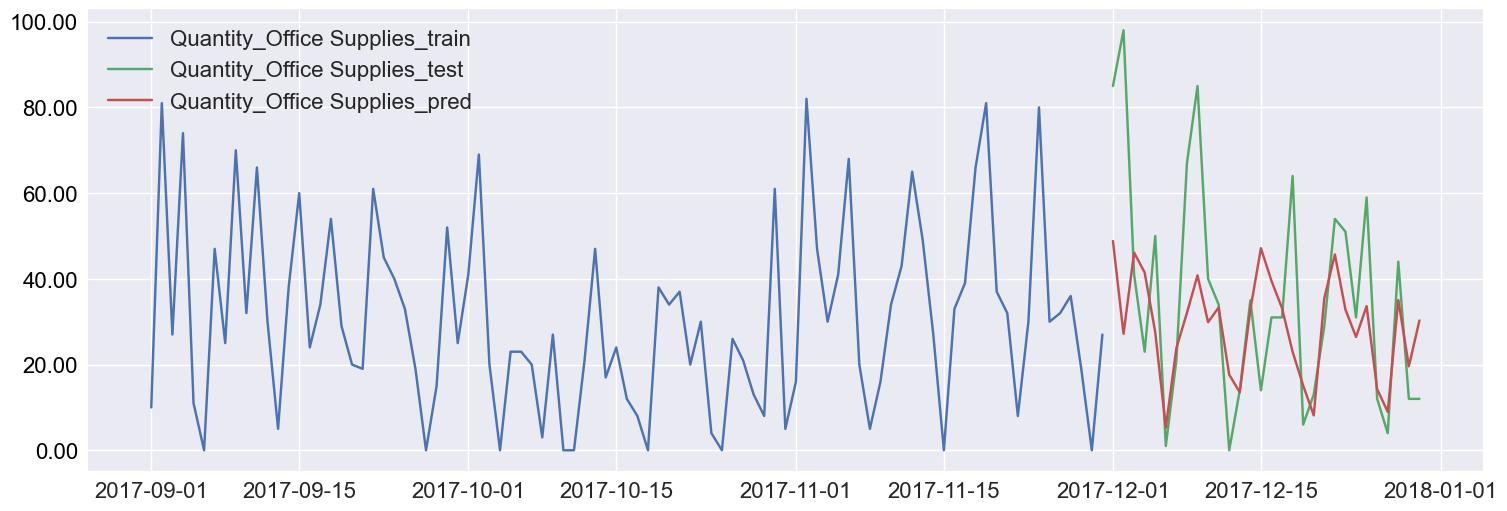

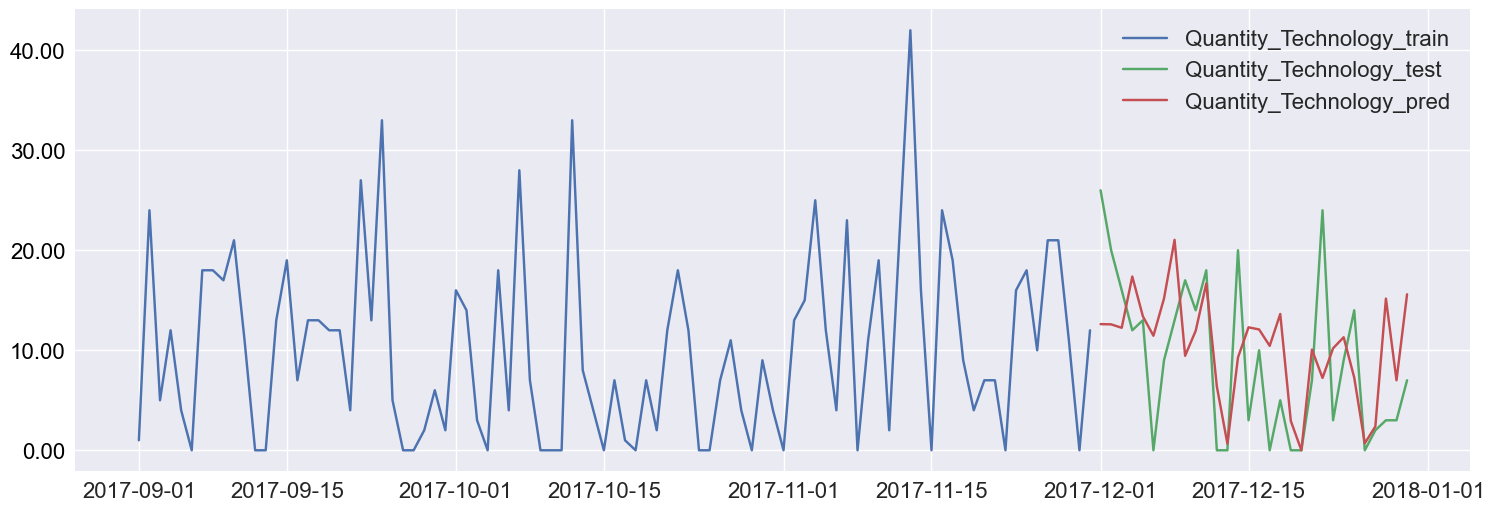

In [41]:

dfxgbmv = dfXY_pred_xgbmv.reset_index().copy() # seaborn lineplot function needs x-axis to be a column
d=datetime(2017,9,1)

y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

bp.lineplot(dfxgbmv[dfxgbmv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,6) , legend=True)


y =  "Quantity_Office Supplies" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

bp.lineplot(dfxgbmv[dfxgbmv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,6) , legend=True)

y =  "Quantity_Technology" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

bp.lineplot(dfxgbmv[dfxgbmv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,6) , legend=True)

### Multivariate,Exogenous, Endogenous, Multiple Outputs, Nhorizon > 1

* This case is again very similar to the previous examples, with the difference that the forecast horizon is 5 periods between model re-training
* Again we inclue the co-variate variables but now we also forecast the co-variates
* In this case, sforecast loops through these variables and creates the forecasts
* Note that for more advanced types of models, such as deep-learning models the multivarites forecasts can be generated simultaneously
* We display the upper and lower prediction bounds, included with the prediction output.

In [42]:
dfXY = dfXYw[["Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]].copy()
# Exogenous Variables
dfXY["dayofweek"] = dfXY.index.dayofweek

display(dfXY.tail())


y = [ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]
Ntest= 30
Nhorizon = 5

# sliding forecast inputs
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":40,
    "minmax" :(0,None),
    "covars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"],
    "exogvars":"dayofweek",
    "derived_attributes_transform":derived_attributes_3 # Endogenous Variables
    } 


xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

# sliding forecast model and forecast
sfxgbmv = sf.sforecast(y = y, swin_parameters=swin_params,model=xgb_model,model_type="sk")
df_pred_xgbmv = sfxgbmv.fit(dfXY)


print(f'\nmetrics = {sfxgbmv.metrics}')

dfXY_pred_xgbmv = dfXY.join(df_pred_xgbmv)
display(dfXY_pred_xgbmv)

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,dayofweek
Order Date,,,,
2017-12-26,0.0,12.0,0.0,1
2017-12-27,0.0,4.0,2.0,2
2017-12-28,17.0,44.0,3.0,3
2017-12-29,26.0,12.0,3.0,4
2017-12-30,4.0,12.0,7.0,5



metrics = {'Quantity_Furniture_pred': {'RMSE': 9.976216299383216, 'MAE': 7.866652846336365}, 'Quantity_Office Supplies_pred': {'RMSE': 23.934072907054958, 'MAE': 17.96384661992391}, 'Quantity_Technology_pred': {'RMSE': 7.2867655310880295, 'MAE': 6.050153358777364}}


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,dayofweek,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper,...,Quantity_Office Supplies_pred,Quantity_Office Supplies_pred_error,Quantity_Office Supplies_pred_lower,Quantity_Office Supplies_pred_upper,Quantity_Technology_train,Quantity_Technology_test,Quantity_Technology_pred,Quantity_Technology_pred_error,Quantity_Technology_pred_lower,Quantity_Technology_pred_upper
Order Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,0.0,2.0,0.0,4,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,8.0,0.0,5,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,3.0,0.0,6,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,15.0,6.0,0,9.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,7.0,0.0,1,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,0.0,12.0,0.0,1,NaN,0.0,6.255946,6.255946,0.000000,14.370791,...,14.250632,2.250632,0.000000,21.759099,NaN,0.0,0.700436,0.700436,0.000000,7.959930
2017-12-27,0.0,4.0,2.0,2,NaN,0.0,7.713229,7.713229,0.000000,19.176550,...,7.449195,3.449195,0.000000,29.451348,NaN,2.0,0.000000,-2.000000,0.000000,8.618991
2017-12-28,17.0,44.0,3.0,3,NaN,17.0,12.548862,-4.451138,0.000000,12.967516,...,27.508463,-16.491537,0.000000,29.400260,NaN,3.0,11.540922,8.540922,7.949812,22.040194


plot the observations, predicted output, and test (observations during corresponding to the predictions)

illustrate the confidence interval around the predictions. Sforecast defaults to 80% confidence periods, however the desired confidence interval can be specified as an input parameter.

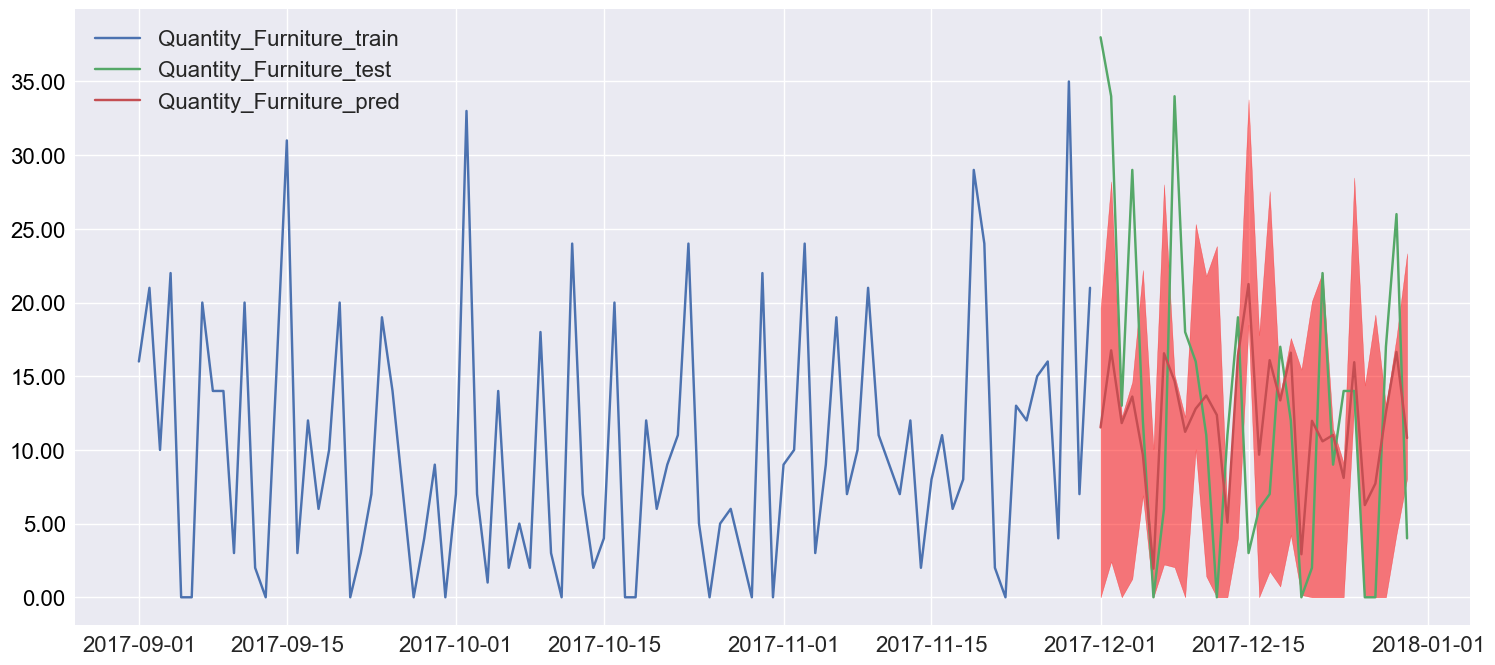

In [43]:
y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfxgbmv = dfXY_pred_xgbmv.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

yfillbetween = (y+"_pred_lower",y+"_pred_upper")

d=datetime(2017,9,1)
bp.lineplot(dfxgbmv[dfxgbmv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , yfb=yfillbetween, figsize=(18,8) , legend=True)

**predict multi-output multivariat w/ exogenous and endogenous/derived variablese**

In [44]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"dayofweek":[2,3,4,5,6]})
df_pred=sfxgbmv.predict(Nperiods=5,dfexogs = dfexogs, ts_period=ts_period)
df_pred

,Quantity_Furniture_pred,Quantity_Office Supplies_pred,Quantity_Technology_pred
2017-12-31,10.596957,21.441370,13.699134
2018-01-01,11.101211,35.620289,6.676338
2018-01-02,8.706774,9.433600,7.046351
2018-01-03,5.279029,25.375715,4.803581
2018-01-04,5.839658,31.635773,10.914982


fit example using all training observations, Npred = 0